dataset：<br>
https://github.com/DataScience-in-Tourism 
The sample dataset for this chapter includes a few rows.
so in this file, the sample dataset has been replaced with the dataset from Disneyland on Kaggle (TripAdvisor). The codes has been adjusted accordingly, correcting a few mistakes. <p>
    
The dataset from Disneyland on Kaggle (TripAdvisor) <p>
https://www.kaggle.com/datasets/arushchillar/disneyland-reviews  <br>
    
About Dataset <br>
The dataset includes 42,000 reviews of 3 Disneyland branches - Paris, California and Hong Kong, posted by visitors on Trip Advisor.
<br>
Column Description:<br>

Review_ID: unique id given to each review <br>
Rating: ranging from 1 (unsatisfied) to 5 (satisfied)<br>
Year_Month: when the reviewer visited the theme park<br>
Reviewer_Location: country of origin of visitor<br>
Review_Text: comments made by visitor<br>
Disneyland_Branch: location of Disneyland Park<br>

# 1.basic

## 1.1 load libraries

In [1]:
# If an error occurs during execution due to a missing library, please install that library using either pip or conda. 

# Import libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy, re
from gensim import corpora, models, similarities, matutils
import string
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet, sentiwordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import time
import emoji
    
# import metrics to show accuracy, recall, precision and ...
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.metrics import precision_recall_fscore_support as prf_score

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon') # vader sentiment
nltk.download('sentiwordnet') # sentiwordnet sentiment

stemmer = PorterStemmer()
sentiment_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaiwu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kaiwu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaiwu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kaiwu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\kaiwu\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


## 1.2 define the overview function

In [6]:
# data overview
def df_overview(df):
    print ('Rows     : ', df.shape[0])
    print ('Columns  : ', df.shape[1])
    print ('\nFeatures : ', df.columns.tolist())
    print ('\nMissing values :  ', df.isnull().sum().values.sum())
    print ('\nUnique values :  \n', df.nunique())
    return df.shape[0]

## 1.3 set the data folder

In [7]:
datafolder='D:/tdata/sentiment_analysis/'

## 1.4 import the datasets

In [8]:
# Import Dataset and remove empty rows
raw_df = pd.read_csv(datafolder+'DisneylandReviews.csv',index_col=0,encoding='ISO-8859-1')
df = raw_df.fillna("")

In [5]:
df.dtypes

Rating                int64
Year_Month           object
Reviewer_Location    object
Review_Text          object
Branch               object
dtype: object

In [9]:
df.head(6)

Rating Year_Month     Reviewer_Location  \
Review_ID                                            
670772142       4     2019-4             Australia   
670682799       4     2019-5           Philippines   
670623270       4     2019-4  United Arab Emirates   
670607911       4     2019-4             Australia   
670607296       4     2019-4        United Kingdom   
670591897       3     2019-4             Singapore   

                                                 Review_Text  \
Review_ID                                                      
670772142  If you've ever been to Disneyland anywhere you...   
670682799  Its been a while since d last time we visit HK...   
670623270  Thanks God it wasn   t too hot or too humid wh...   
670607911  HK Disneyland is a great compact park. Unfortu...   
670607296  the location is not in the city, took around 1...   
670591897  Have been to Disney World, Disneyland Anaheim ...   

                        Branch  
Review_ID                       
670772142  Disneyland_HongKong  
670682799  Disneyland_HongKong  
670623270  Disneyland_HongKong  
670607911  Disneyland_HongKong  
670607296  Disneyland_HongKong  
670591897  Disneyland_HongKong

In [10]:
# for this dataset, the index of the dataframe is the 'Review_ID'
df['Review_ID']=df.index

In [11]:
df.head(6)

Rating Year_Month     Reviewer_Location  \
Review_ID                                            
670772142       4     2019-4             Australia   
670682799       4     2019-5           Philippines   
670623270       4     2019-4  United Arab Emirates   
670607911       4     2019-4             Australia   
670607296       4     2019-4        United Kingdom   
670591897       3     2019-4             Singapore   

                                                 Review_Text  \
Review_ID                                                      
670772142  If you've ever been to Disneyland anywhere you...   
670682799  Its been a while since d last time we visit HK...   
670623270  Thanks God it wasn   t too hot or too humid wh...   
670607911  HK Disneyland is a great compact park. Unfortu...   
670607296  the location is not in the city, took around 1...   
670591897  Have been to Disney World, Disneyland Anaheim ...   

                        Branch  Review_ID  
Review_ID                                  
670772142  Disneyland_HongKong  670772142  
670682799  Disneyland_HongKong  670682799  
670623270  Disneyland_HongKong  670623270  
670607911  Disneyland_HongKong  670607911  
670607296  Disneyland_HongKong  670607296  
670591897  Disneyland_HongKong  670591897

In [12]:
#split the "Year_Month" into review_year and review_onth
new = df["Year_Month"].str.split("-", n = 1, expand = True)

df["review_year"]=new[0]
df["review_month"]= new[1]

In [13]:
df.dtypes

Rating                int64
Year_Month           object
Reviewer_Location    object
Review_Text          object
Branch               object
Review_ID             int64
review_year          object
review_month         object
dtype: object

In [14]:
#Transform 'review_year' and 'review_month' (string or object) into integer 
df["review_year"] = pd.to_numeric(df["review_year"], errors="coerce")
df["review_year"].fillna('0', inplace=True)
df["review_year"]=df["review_year"].astype(int)


df["review_month"] = pd.to_numeric(df["review_month"], errors="coerce")
df["review_month"].fillna('0', inplace=True)
df["review_month"]=df["review_month"].astype(int)

In [15]:
df.dtypes

Rating                int64
Year_Month           object
Reviewer_Location    object
Review_Text          object
Branch               object
Review_ID             int64
review_year           int32
review_month          int32
dtype: object

In [16]:
df.head(10)

Rating Year_Month     Reviewer_Location  \
Review_ID                                            
670772142       4     2019-4             Australia   
670682799       4     2019-5           Philippines   
670623270       4     2019-4  United Arab Emirates   
670607911       4     2019-4             Australia   
670607296       4     2019-4        United Kingdom   
670591897       3     2019-4             Singapore   
670585330       5     2019-4                 India   
670574142       3     2019-3              Malaysia   
670571027       2     2019-4             Australia   
670570869       5     2019-3                 India   

                                                 Review_Text  \
Review_ID                                                      
670772142  If you've ever been to Disneyland anywhere you...   
670682799  Its been a while since d last time we visit HK...   
670623270  Thanks God it wasn   t too hot or too humid wh...   
670607911  HK Disneyland is a great compact park. Unfortu...   
670607296  the location is not in the city, took around 1...   
670591897  Have been to Disney World, Disneyland Anaheim ...   
670585330  Great place! Your day will go by and you won't...   
670574142  Think of it as an intro to Disney magic for th...   
670571027  Feel so let down with this place,the Disneylan...   
670570869  I can go on talking about Disneyland. Whatever...   

                        Branch  Review_ID  review_year  review_month  
Review_ID                                                             
670772142  Disneyland_HongKong  670772142         2019             4  
670682799  Disneyland_HongKong  670682799         2019             5  
670623270  Disneyland_HongKong  670623270         2019             4  
670607911  Disneyland_HongKong  670607911         2019             4  
670607296  Disneyland_HongKong  670607296         2019             4  
670591897  Disneyland_HongKong  670591897         2019             4  
670585330  Disneyland_HongKong  670585330         2019             4  
670574142  Disneyland_HongKong  670574142         2019             3  
670571027  Disneyland_HongKong  670571027         2019             4  
670570869  Disneyland_HongKong  670570869         2019             3

In [17]:
#rename variables

df.columns = ['rating','review_date','country', 'review', 'branch', 'review_id','review_year','review_month']

curr_rows = df_overview(df)

Rows     :  42656
Columns  :  8

Features :  ['rating', 'review_date', 'country', 'review', 'branch', 'review_id', 'review_year', 'review_month']

Missing values :   0

Unique values :  
 rating              5
review_date       112
country           162
review          42632
branch              3
review_id       42636
review_year        11
review_month       13
dtype: int64


# 2.data clean

In [19]:
#display all rows and all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 2.1 look through the dataset

In [20]:
# the frequency of review_year
df['review_year'].value_counts()[df.review_year.unique()]

2019     786
2018    3997
0       2613
2017    5195
2016    6599
2015    6979
2014    5301
2013    4717
2012    4342
2011    1984
2010     143
Name: review_year, dtype: int64

<BarContainer object of 3 artists>

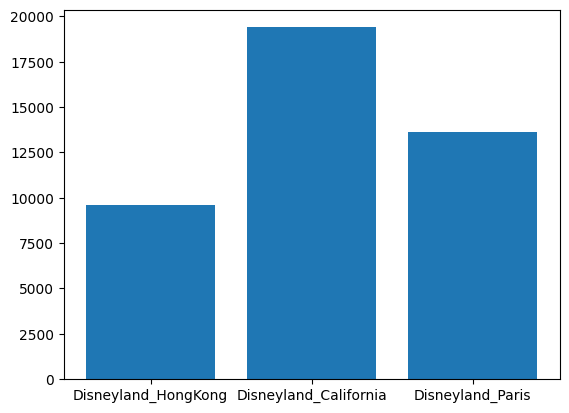

In [21]:
# "Branch refers to branches of Disneyland, and the dataset includes reviews from three Disneyland branches."
from collections import Counter
plt.bar(dict(Counter(df['branch'] )).keys(), dict(Counter(df['branch'])).values())

## 2.2subset of the dataset

In [22]:
#  reviews from Disneyland_HongKong ,9620 records
df_hk=  df[df['branch'] == "Disneyland_HongKong"]
df_hk.shape

(9620, 8)

In [23]:
#Hong Kong Disneyland were with 786 reviews in 2019, with 211 reviews in January 2019.
df_hk=  df[df['review_year'] == 2019]
df_hk=  df_hk[df_hk['review_month'] == 1]
df_hk.shape

(211, 8)

# 3.Dictionary-based Sentiment Analysis

## 3.1 define the functions for sentiment analysis

In [24]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [25]:
# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_word_sentiment(word, tag):
    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wordnet.synsets(word, pos=tag)
    
    if not synsets:
        return ['', 0, 0, 0]

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = sentiwordnet.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [26]:
def get_sentiment(text):
    pos_tags = pos_tag(text.split())
    pos_score, neg_score, obj_score, word_count = 0, 0, 0, 0
    for word, tag in pos_tags:
        res = get_word_sentiment(word, get_wordnet_pos(tag))
        pos_score += res[1]
        neg_score += res[2]
        obj_score += res[3]
        word_count += 1
        
    return [pos_score/word_count, neg_score/word_count, obj_score/word_count]

In [27]:
def clean_text(text):
    # lower the text
    text = text.lower()
    
    # remove hyperlink
    text = re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    # ad-hoc remove
    text = text.replace("cr ", "costa rica ").replace("CR ", "costa rica")\
    .replace("manual ", "manuel ").replace("Manual ", "manuel ")\
    .replace("manuel antonio", "").replace("esp ", "especially ").replace("parc ", "park ")\
    .replace("&quot;", "").replace("&#39;", "'").replace("；", ";")\
    .replace("。", ".").replace("，", ",").replace("’", "'").replace("‘", "'").replace("`", "'")
    
    # spelling check
    from textblob import TextBlob
    text = str(TextBlob(text).correct())
    
    # converting emoji
    text = emoji.demojize(text)
    text = re.sub(r':[a-z_&]+:', '', text)

    # replace all types of negations: no, n't, never
    text = text.replace("he's", "he is").replace("I'm", "I am").replace("'re", " are").replace("ain't", "are not")\
    .replace("'ve", " have").replace("'ll", " will").replace("won't", "will not").replace("can't", "can not")\
    .replace("n't", " not").replace("'d", " would")
    
    # remove all symbols
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    # tokenize the text with removal of non-words,  punctuation, short (< 3 symbols) and long (> 25 symbols) tokens
    text = [word.strip() for word in text.split() if len(word.strip()) >= 3 and len(word.strip()) <= 25]

    # filtering English stopwords, and remove digits
    stop = stopwords.words('english')
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if word not in stop]

    # Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database (retaining nouns and adjectives)
    pos_tags = pos_tag(text)
    pos_tags = list(filter(lambda x: get_wordnet_pos(x[1]) is not None, pos_tags))
    text = [w for w, t in pos_tags if get_wordnet_pos(t) == wordnet.NOUN or get_wordnet_pos(t) == wordnet.ADJ]

    # stemming (reducing inflected words to their word stems using Porter stemmer)
    text = [stemmer.stem(word) for word in text]

    # lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)
    text = [WordNetLemmatizer().lemmatize(w, get_wordnet_pos(t)) for w, t in pos_tags]
    
    # join the token
    text = ' '.join(text)
    return(text)

## 3.2data clean for the review text

In [23]:
## Resolve Western European character issues


from unidecode import unidecode
df_hk["review"]=df_hk["review"].map(unidecode)


This step takes a considerable amount of time to run<p>
it costs 153.3511610031128 seconds 211 records (January 2019,Disneyland HongKong)<p>
it costs 544.5189340114594 seconds 786 records (2019, Disneyland_HongKong)



In [24]:

import time
 
# record start time
start = time.time()
 

df_hk["review_clean"] = df_hk["review"].apply(lambda x: clean_text(x))
df_hk.head(5)

# record end time
end = time.time()
 
# print the difference between start
# and end time in milli. secs
print("The time of execution of above program is :",
      (end-start) , "s")

The time of execution of above program is : 160.3825659751892 s


In [28]:
df_hk.head(5)

rating review_date         country  \
Review_ID                                       
670205135       3      2019-1  United Kingdom   
666542833       5      2019-1   United States   
666297074       5      2019-1           India   
657475578       5      2019-1       Hong Kong   
655891314       5      2019-1     New Zealand   

                                                      review  \
Review_ID                                                      
670205135  We brought tickets before we left and got 2 da...   
666542833  Love this place very clean and safe have it ow...   
666297074  I would recommend to go through below tips to ...   
657475578  My journey started and ended with this magical...   
655891314  HK Disney is the smallest of the Disney Parks ...   

                        branch  review_id  review_year  review_month  
Review_ID                                                             
670205135  Disneyland_HongKong  670205135         2019             1  
666542833  Disneyland_HongKong  666542833         2019             1  
666297074  Disneyland_HongKong  666297074         2019             1  
657475578  Disneyland_HongKong  657475578         2019             1  
655891314  Disneyland_HongKong  655891314         2019             1

## 3.3 Calculate Sentiment Scores

In [26]:
# (VADER) add sentiment anaylsis columns
df_hk["sentiments"] = df_hk["review_clean"].apply(lambda x: sentiment_analyzer.polarity_scores(x))
df_hk = pd.concat([df_hk.drop(['sentiments'], axis=1), df_hk['sentiments'].apply(pd.Series)], axis=1)
df_hk.head(5)

rating review_date         country  \
Review_ID                                       
670205135       3      2019-1  United Kingdom   
666542833       5      2019-1   United States   
666297074       5      2019-1           India   
657475578       5      2019-1       Hong Kong   
655891314       5      2019-1     New Zealand   

                                                      review  \
Review_ID                                                      
670205135  We brought tickets before we left and got 2 da...   
666542833  Love this place very clean and safe have it ow...   
666297074  I would recommend to go through below tips to ...   
657475578  My journey started and ended with this magical...   
655891314  HK Disney is the smallest of the Disney Parks ...   

                        branch  review_id  review_year  review_month  \
Review_ID                                                              
670205135  Disneyland_HongKong  670205135         2019             1   
666542833  Disneyland_HongKong  666542833         2019             1   
666297074  Disneyland_HongKong  666297074         2019             1   
657475578  Disneyland_HongKong  657475578         2019             1   
655891314  Disneyland_HongKong  655891314         2019             1   

                                                review_clean    neg    neu  \
Review_ID                                                                    
670205135  brought ticket leave get day less price visit ...  0.024  0.798   
666542833  love place clean safe meet get night time beau...  0.000  0.338   
666297074  recommend tip navigable easily manage time mar...  0.035  0.687   
657475578  journey start end magical sentence disneyland ...  0.000  0.640   
655891314  dinner small dinner part definitely something ...  0.094  0.706   

             pos  compound  
Review_ID                   
670205135  0.178    0.7746  
666542833  0.662    0.9287  
666297074  0.278    0.9831  
657475578  0.360    0.9442  
655891314  0.200    0.9489

In [27]:
# sentiwordnet sentiment
df_hk["sentiments"] = df_hk["review_clean"].apply(lambda x: get_sentiment(x))
df_hk = pd.concat([df_hk.drop(['sentiments'], axis=1), df_hk['sentiments'].apply(pd.Series)], axis=1)
df_hk.columns = ['rating', 'review_date','country','review','branch','author','review_year','review_month', 'cleaned_review', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'swn_pos', 'swn_neg', 'swn_obj']
df_hk.head(5)

rating review_date         country  \
Review_ID                                       
670205135       3      2019-1  United Kingdom   
666542833       5      2019-1   United States   
666297074       5      2019-1           India   
657475578       5      2019-1       Hong Kong   
655891314       5      2019-1     New Zealand   

                                                      review  \
Review_ID                                                      
670205135  We brought tickets before we left and got 2 da...   
666542833  Love this place very clean and safe have it ow...   
666297074  I would recommend to go through below tips to ...   
657475578  My journey started and ended with this magical...   
655891314  HK Disney is the smallest of the Disney Parks ...   

                        branch     author  review_year  review_month  \
Review_ID                                                              
670205135  Disneyland_HongKong  670205135         2019             1   
666542833  Disneyland_HongKong  666542833         2019             1   
666297074  Disneyland_HongKong  666297074         2019             1   
657475578  Disneyland_HongKong  657475578         2019             1   
655891314  Disneyland_HongKong  655891314         2019             1   

                                              cleaned_review  vader_neg  \
Review_ID                                                                 
670205135  brought ticket leave get day less price visit ...      0.024   
666542833  love place clean safe meet get night time beau...      0.000   
666297074  recommend tip navigable easily manage time mar...      0.035   
657475578  journey start end magical sentence disneyland ...      0.000   
655891314  dinner small dinner part definitely something ...      0.094   

           vader_neu  vader_pos  vader_compound   swn_pos   swn_neg   swn_obj  
Review_ID                                                                      
670205135      0.798      0.178          0.7746  0.025000  0.019444  0.866667  
666542833      0.338      0.662          0.9287  0.204545  0.068182  0.727273  
666297074      0.687      0.278          0.9831  0.050971  0.009709  0.735437  
657475578      0.640      0.360          0.9442  0.026786  0.020833  0.761905  
655891314      0.706      0.200          0.9489  0.049180  0.025615  0.744877

## 3.4 save the dataset

In [28]:
df_hk.index += 1
df_hk.to_csv(datafolder+'sentiment_hk_disneyland2019Jan.csv', encoding='utf-8-sig')
#df_hk.to_csv(datafolder+'sentiment_hk_disneyland2019.csv', encoding='utf-8-sig')

# 4.sentiment analysis based on machine learning

## 4.1 load the dataset

In [29]:
df2 = pd.read_csv(datafolder+'sentiment_hk_disneyland2019Jan.csv', encoding='utf8')
df2.shape

(211, 17)

## 4.2 split the dataset into two datasets: train，test

In [30]:
from sklearn.model_selection import train_test_split
#10% for test， 90% for train
train, test = train_test_split(df2, test_size=0.1, random_state=0)

In [31]:
train.shape

(189, 17)

In [32]:
test.shape

(22, 17)

## 4.3 test dataset

In [33]:
# we have 2700 rows of data in total,
# label first ~10% data in sentiment-manual-antonio.csv by review rating. 
# label -1 if review rating below and equal to 3; 
# label 1 if review rating over and equal to 4.
# so we will have ~90% data left for training and validation
test['label'] = np.where(test['rating']<=3, -1, 1)



TRAIN_AND_VALIDATION_END_INDEX = 189


test.head()

Review_ID  rating review_date         country  \
173  648318759       5      2019-1  United Kingdom   
74   656528000       5      2019-1        Tanzania   
12   650850342       5      2019-1        Malaysia   
5    655549219       5      2019-1       Indonesia   
55   644673957       4      2019-1       Indonesia   

                                                review                 branch  \
173  Yes, it's pricy and it lacks some of the favou...       Disneyland_Paris   
74   I love all things Disney.  The park is very cl...  Disneyland_California   
12   Although this is the smallest Disneyland in th...    Disneyland_HongKong   
5    We visited Hong Kong Disneyland as group of fa...    Disneyland_HongKong   
55   I assume its smaller than the one in Tokyo. Tr...    Disneyland_HongKong   

        author  review_year  review_month  \
173  648318758         2019             1   
74   656527999         2019             1   
12   650850341         2019             1   
5    655549218         2019             1   
55   644673956         2019             1   

                                        cleaned_review  vader_neg  vader_neu  \
173  yes price lack favourite american dinner part ...      0.062      0.677   
74   love thing dinner park clean pay lot food drin...      0.067      0.481   
12   small disneyland world discount value definite...      0.000      0.417   
5    visit long long disneyland group family januar...      0.053      0.583   
55   assume small tokyo try ride extreme rain cause...      0.213      0.628   

     vader_pos  vader_compound   swn_pos   swn_neg   swn_obj  label  
173      0.261          0.9834  0.067383  0.022461  0.707031      1  
74       0.452          0.8402  0.071429  0.044643  0.812500      1  
12       0.583          0.7184  0.062500  0.046875  0.890625      1  
5        0.364          0.9919  0.056250  0.050000  0.733750      1  
55       0.159         -0.3182  0.039474  0.092105  0.868421      1

In [34]:
test.dtypes

Review_ID           int64
rating              int64
review_date        object
country            object
review             object
branch             object
author              int64
review_year         int64
review_month        int64
cleaned_review     object
vader_neg         float64
vader_neu         float64
vader_pos         float64
vader_compound    float64
swn_pos           float64
swn_neg           float64
swn_obj           float64
label               int32
dtype: object

In [35]:
# test set
TEST_SET_END_INDEX = 22
test_labels = []
test_reviews = []

vader_tp = 0
vader_fp = 0
vader_tn = 0
vader_fn = 0
vader_pos = 0
vader_neg = 0
vader_neu = 0

wn_tp = 0
wn_fp = 0
wn_tn = 0
wn_fn = 0
wn_pos = 0
wn_neg = 0
wn_neu = 0

num_of_test = 0
cnt_neutral = 0
for index in range(0, TEST_SET_END_INDEX):
    vader_score = float(test['vader_compound'].iloc[index])
    wn_score = float(test['swn_pos'].iloc[index])-float(test['swn_neg'].iloc[index])
    label_val = int(test['label'].iloc[index])
    
    num_of_test += 1
    
    test_labels.append(test['label'].iloc[index])
    test_reviews.append(test['cleaned_review'].iloc[index])
    
    if (vader_score < 0.05 and vader_score > -0.05) or wn_score == 0:
        cnt_neutral += 1
        
    else:        
        vader_final = 1 if vader_score >= 0.05 else -1
        wn_final = 1 if wn_score > 0 else -1

        vader_tp += 1 if vader_final == label_val and label_val == 1 else 0
        vader_tn += 1 if vader_final == label_val and label_val == -1 else 0
        vader_fn += 1 if vader_final != label_val and label_val == 1 else 0
        vader_fp += 1 if vader_final != label_val and label_val == -1 else 0

        wn_tp += 1 if wn_final == label_val and label_val == 1 else 0
        wn_tn += 1 if wn_final == label_val and label_val == -1 else 0
        wn_fn += 1 if wn_final != label_val and label_val == 1 else 0
        wn_fp += 1 if wn_final != label_val and label_val == -1 else 0
        
    if vader_score < 0.05 and vader_score > -0.05:
        vader_neu += 1
    elif vader_score >= 0.05:
        vader_pos += 1
    else:
        vader_neg += 1
            
    if wn_score == 0:
        wn_neu += 1
    elif wn_score >0:
        wn_pos += 1
    else:
        wn_neg += 1

vader_accuracy_score = (vader_tp + vader_fn)/(num_of_test - cnt_neutral)
vader_precision_score = vader_tp/(vader_tp + vader_fp)
vader_recall_score = vader_tp/(vader_tp + vader_fn)
vader_f1_score = 2 * (vader_precision_score * vader_recall_score) / (vader_precision_score + vader_recall_score)

    
print("=== Vader ===\n")
print("TruePositive: %d" % vader_tp)
print("TrueNegative: %d" % vader_tn)
print("FalsePositive: %d" % vader_fp)
print("FalseNegative: %d\n" % vader_fn)
print("Accuracy Score: %f" % vader_accuracy_score)
print("Precision Score: %f" % vader_precision_score)
print("Recall Score: %f" % vader_recall_score)
print("F1 Score: %f\n" % vader_f1_score)
# in 300
print("Positive: %d" % vader_pos)
print("Negative: %d" % vader_neg)
print("Neutral: %d\n" % vader_neu)


wn_accuracy_score = (wn_tp + wn_fn)/(num_of_test - cnt_neutral)
wn_precision_score = wn_tp/(wn_tp + wn_fp)
wn_recall_score = wn_tp/(wn_tp + wn_fn)
wn_f1_score = 2 * (wn_precision_score * wn_recall_score) / (wn_precision_score + wn_recall_score)

    
print("=== Sentiment WordNet ===\n")
print("TruePositive: %d" % wn_tp)
print("TrueNegative: %d" % wn_tn)
print("FalsePositive: %d" % wn_fp)
print("FalseNegative: %d\n" % wn_fn)
print("Accuracy Score: %f" % wn_accuracy_score)
print("Precision Score: %f" % wn_precision_score)
print("Recall Score: %f" % wn_recall_score)
print("F1 Score: %f\n" % wn_f1_score)
# in 300
print("Positive: %d" % wn_pos)
print("Negative: %d" % wn_neg)
print("Neutral: %d" % wn_neu)

print("Removed neutral [%d] reviews" % cnt_neutral)
print("# of Test -> %d" % num_of_test)
test_reviews_tokens = [r for r in test_reviews]

=== Vader ===

TruePositive: 15
TrueNegative: 1
FalsePositive: 3
FalseNegative: 3

Accuracy Score: 0.818182
Precision Score: 0.833333
Recall Score: 0.833333
F1 Score: 0.833333

Positive: 18
Negative: 4
Neutral: 0

=== Sentiment WordNet ===

TruePositive: 12
TrueNegative: 1
FalsePositive: 3
FalseNegative: 6

Accuracy Score: 0.818182
Precision Score: 0.800000
Recall Score: 0.666667
F1 Score: 0.727273

Positive: 15
Negative: 7
Neutral: 0
Removed neutral [0] reviews
# of Test -> 22


## 4.4 train dataset

In [36]:
# training and validation set
train['label'] = np.where(train['rating']<=3, -1, 1)

labels = []
reviews = []
TEST_SET_END_INDEX=22
TRAIN_AND_VALIDATION_END_INDEX=189

num_of_train_and_validation = 0
for index in range(0, TRAIN_AND_VALIDATION_END_INDEX):
    labels.append(train['label'].iloc[index])
    reviews.append(train['cleaned_review'].iloc[index])
    
    num_of_train_and_validation += 1

print("# of Train and Validation -> %d" % num_of_train_and_validation)
reviews_tokens = [r for r in reviews]

# of Train and Validation -> 189


In [37]:
# manual split data into training set and test set
x_train = reviews_tokens
x_test = test_reviews_tokens
y_train = labels
y_test = test_labels

In [38]:
# encoding label using LabelEncoder()
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

MIN_FEATURE = 100 # inclusive
MAX_FEATURE = 7100 # exclusive
FEATURE_INTERVAL = 100

# load the module to transform our review inputs into word vectors using TfidVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

training_methods = []

# metrics 
metrics = {"performance": [], "accuracy": [], "cross_val": [], "f1": [], "precision": [], "recall": []}

# create our SVM classifier with the class LinearSVC
from sklearn.svm import LinearSVC
training_methods.append((LinearSVC(), "linear svc", copy.deepcopy(metrics)))

# create our Bayes classifier with the BernoulliNB
from sklearn.naive_bayes import BernoulliNB
training_methods.append((BernoulliNB(binarize=None), "bayes with bernoulliNB", copy.deepcopy(metrics)))

# create our Bayes classifier with the MultinomialNB
from sklearn.naive_bayes import MultinomialNB
training_methods.append((MultinomialNB(), "bayes with multinomialNB", copy.deepcopy(metrics)))

# x_train = vectorizer.fit_transform(x_train)

for n_features in range(MIN_FEATURE, MAX_FEATURE, FEATURE_INTERVAL):
    # print("------------------------------------\n")
    # print("nFeatures: %s\n" % n_features)
    tfidf_vect = TfidfVectorizer(max_features=n_features)
    # tfidf_vect.fit(reviews_tokens)

    _x_train = tfidf_vect.fit_transform(x_train)
    _x_test = tfidf_vect.transform(x_test)
     
    # print(tfidf_vect.vocabulary_)
    # print(x_train)
    
    for tm, name, metrics in training_methods:
        tm.fit(_x_train, y_train)
        
        prediction = tm.predict(_x_test)
        
        if n_features == 500:
            print("Model [%s] at [%d] features ->\n" % (name, n_features))
            tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
            print("TruePositive: %d" % tp)
            print("TrueNegative: %d" % tn)
            print("FalsePositive: %d" % fp)
            print("FalseNegative: %d\n" % fn)
        
        _performance_score = tm.score(_x_test, y_test)
        _accuracy_score = accuracy_score(y_test, prediction)
        _f1_score = f1_score(y_test, prediction)
        _precision_score = precision_score(y_test, prediction)    
        _recall_score = recall_score(y_test, prediction)
        
        metrics["performance"].append((n_features, _performance_score))
        metrics["accuracy"].append((n_features, _accuracy_score))
        metrics["f1"].append((n_features, _f1_score))
        metrics["precision"].append((n_features, _precision_score))
        metrics["recall"].append((n_features, _recall_score))

Model [linear svc] at [500] features ->

TruePositive: 16
TrueNegative: 1
FalsePositive: 3
FalseNegative: 2

Model [bayes with bernoulliNB] at [500] features ->

TruePositive: 18
TrueNegative: 0
FalsePositive: 4
FalseNegative: 0

Model [bayes with multinomialNB] at [500] features ->

TruePositive: 18
TrueNegative: 0
FalsePositive: 4
FalseNegative: 0



C:\python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will c

## 4.5 data visualization

In [39]:
# draw the diagram
nfeatures_performance = []
nfeatures_accuracy = []
nfeatures_f1 = []
nfeatures_precision = []
nfeatures_recall = []
for tm, name, metrics in training_methods:
    nfeatures_performance.append((name, pd.DataFrame(metrics['performance'], columns=['n_features', 'performance_score'])))
    nfeatures_accuracy.append((name, pd.DataFrame(metrics['accuracy'], columns=['n_features', 'accuracy_score'])))
    nfeatures_f1.append((name, pd.DataFrame(metrics['f1'], columns=['n_features', 'f1_score'])))
    nfeatures_precision.append((name, pd.DataFrame(metrics['precision'], columns=['n_features', 'precision_score'])))
    nfeatures_recall.append((name, pd.DataFrame(metrics['recall'], columns=['n_features', 'recall_score'])))

=== Performance Score ===

Model Name [linear svc] has max performance score [0.863636] at [100] # of features
Model Name [bayes with bernoulliNB] has max performance score [0.818182] at [100] # of features
Model Name [bayes with multinomialNB] has max performance score [0.818182] at [100] # of features


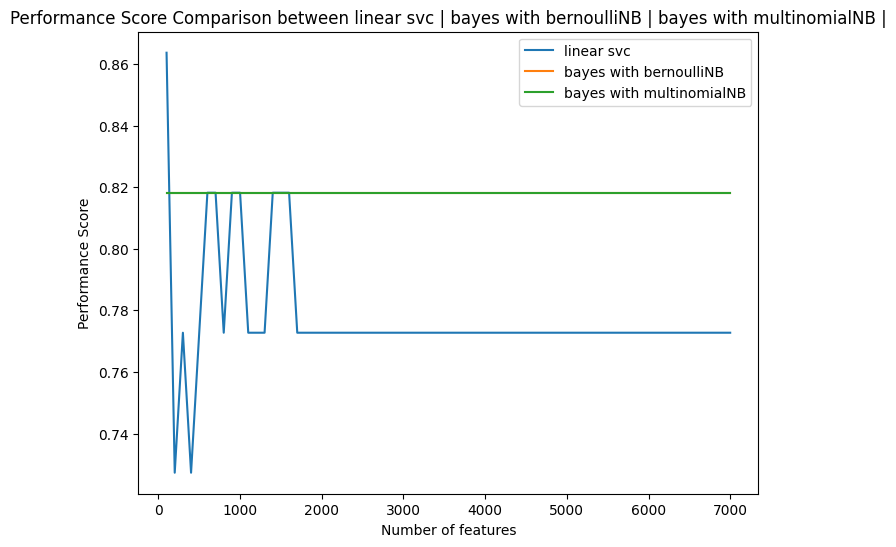

In [40]:
# performance diagram
plt.figure(figsize=(8,6))

title = "Performance Score Comparison between"

for name, df in nfeatures_performance:
    plt.plot(df.n_features, df.performance_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Performance Score")
plt.legend()

print("=== Performance Score ===\n")
for metrics in nfeatures_performance:
    max_performance_score_feature = 0
    max_performance_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _performance_score = metrics[1].loc[feature_index].performance_score
        # print("[%d] features -> [%f] performance score" % (_nfeatures, _performance_score))
        if _performance_score > max_performance_score:
            max_performance_score = _performance_score
            max_performance_score_feature = _nfeatures
    
    print("Model Name [%s] has max performance score [%f] at [%d] # of features" % (metrics[0], max_performance_score, max_performance_score_feature))

=== Accuracy Score ===

Model Name [linear svc] has max accuracy score [0.863636] at [100] # of features
Model Name [bayes with bernoulliNB] has max accuracy score [0.818182] at [100] # of features
Model Name [bayes with multinomialNB] has max accuracy score [0.818182] at [100] # of features


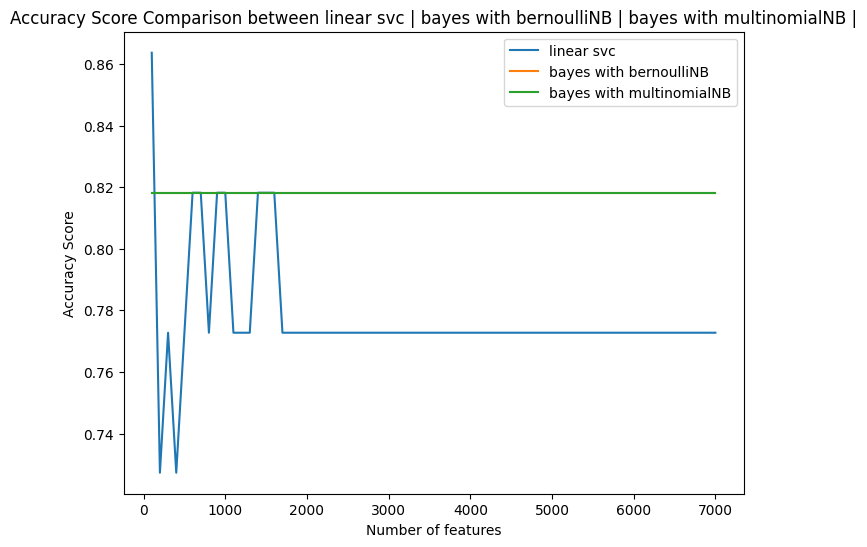

In [41]:
# accuracy diagram
plt.figure(figsize=(8,6))

title = "Accuracy Score Comparison between"

for name, df in nfeatures_accuracy:
    plt.plot(df.n_features, df.accuracy_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Accuracy Score")
plt.legend()

print("=== Accuracy Score ===\n")
for metrics in nfeatures_accuracy:
    max_accuracy_score_feature = 0
    max_accuracy_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _accuracy_score = metrics[1].loc[feature_index].accuracy_score
        # print("[%d] features -> [%f] accuracy score" % (_nfeatures, _accuracy_score))
        if _accuracy_score > max_accuracy_score:
            max_accuracy_score = _accuracy_score
            max_accuracy_score_feature = _nfeatures
    
    print("Model Name [%s] has max accuracy score [%f] at [%d] # of features" % (metrics[0], max_accuracy_score, max_accuracy_score_feature))

=== F1 Score ===

Model Name [linear svc] has max F1 score [0.923077] at [100] # of features
Model Name [bayes with bernoulliNB] has max F1 score [0.900000] at [100] # of features
Model Name [bayes with multinomialNB] has max F1 score [0.900000] at [100] # of features


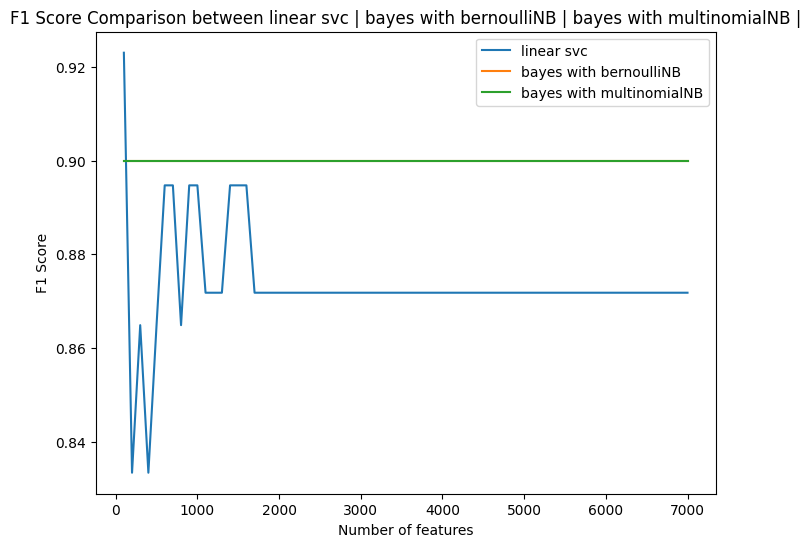

In [42]:
# f1 diagram
plt.figure(figsize=(8,6))

title = "F1 Score Comparison between"

for name, df in nfeatures_f1:
    plt.plot(df.n_features, df.f1_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("F1 Score")
plt.legend()

print("=== F1 Score ===\n")
for metrics in nfeatures_f1:
    max_f1_score_feature = 0
    max_f1_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _f1_score = metrics[1].loc[feature_index].f1_score
        # print("[%d] features -> [%f] F1 score" % (_nfeatures, _f1_score))
        if _f1_score > max_f1_score:
            max_f1_score = _f1_score
            max_f1_score_feature = _nfeatures
    
    print("Model Name [%s] has max F1 score [%f] at [%d] # of features" % (metrics[0], max_f1_score, max_f1_score_feature))

=== Precision Score ===

Model Name [linear svc] has max Precision score [0.857143] at [100] # of features
Model Name [bayes with bernoulliNB] has max Precision score [0.818182] at [100] # of features
Model Name [bayes with multinomialNB] has max Precision score [0.818182] at [100] # of features


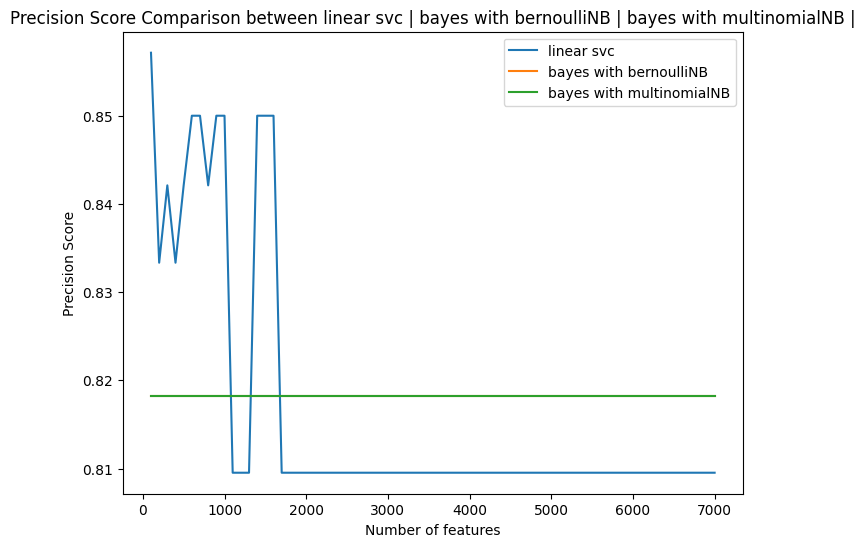

In [43]:
# precision diagram
plt.figure(figsize=(8,6))

title = "Precision Score Comparison between"

for name, df in nfeatures_precision:
    plt.plot(df.n_features, df.precision_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Precision Score")
plt.legend()

print("=== Precision Score ===\n")
for metrics in nfeatures_precision:
    max_precision_score_feature = 0
    max_precision_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _precision_score = metrics[1].loc[feature_index].precision_score
        # print("[%d] features -> [%f] Precision score" % (_nfeatures, _precision_score))
        if _precision_score > max_precision_score:
            max_precision_score = _precision_score
            max_precision_score_feature = _nfeatures
    
    print("Model Name [%s] has max Precision score [%f] at [%d] # of features" % (metrics[0], max_precision_score, max_precision_score_feature))

=== Recall Score ===

Model Name [linear svc] has max Recall score [1.000000] at [100] # of features
Model Name [bayes with bernoulliNB] has max Recall score [1.000000] at [100] # of features
Model Name [bayes with multinomialNB] has max Recall score [1.000000] at [100] # of features


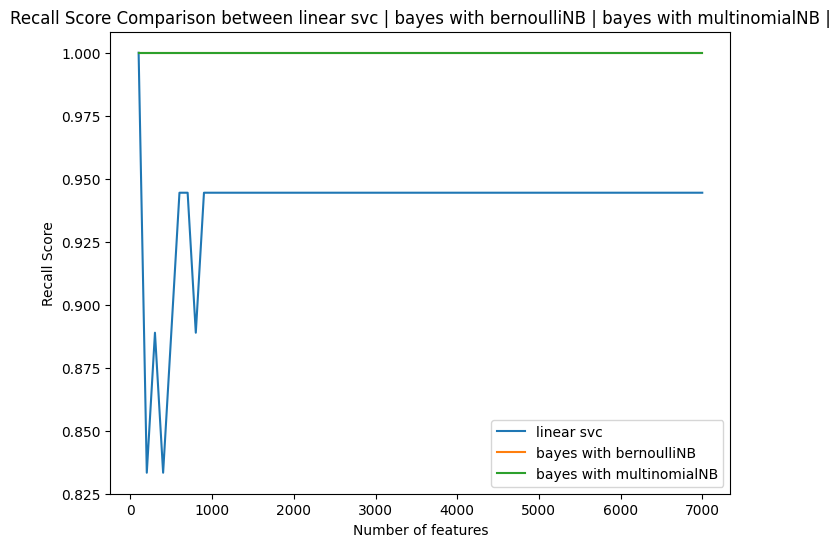

In [44]:
# recall diagram
plt.figure(figsize=(8,6))

title = "Recall Score Comparison between"

for name, df in nfeatures_recall:
    plt.plot(df.n_features, df.recall_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Recall Score")
plt.legend()

print("=== Recall Score ===\n")
for metrics in nfeatures_recall:
    max_recall_score_feature = 0
    max_recall_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _recall_score = metrics[1].loc[feature_index].recall_score
        # print("[%d] features -> [%f] Recall score" % (_nfeatures, _recall_score))
        if _recall_score > max_recall_score:
            max_recall_score = _recall_score
            max_recall_score_feature = _nfeatures
    
    print("Model Name [%s] has max Recall score [%f] at [%d] # of features" % (metrics[0], max_recall_score, max_recall_score_feature))

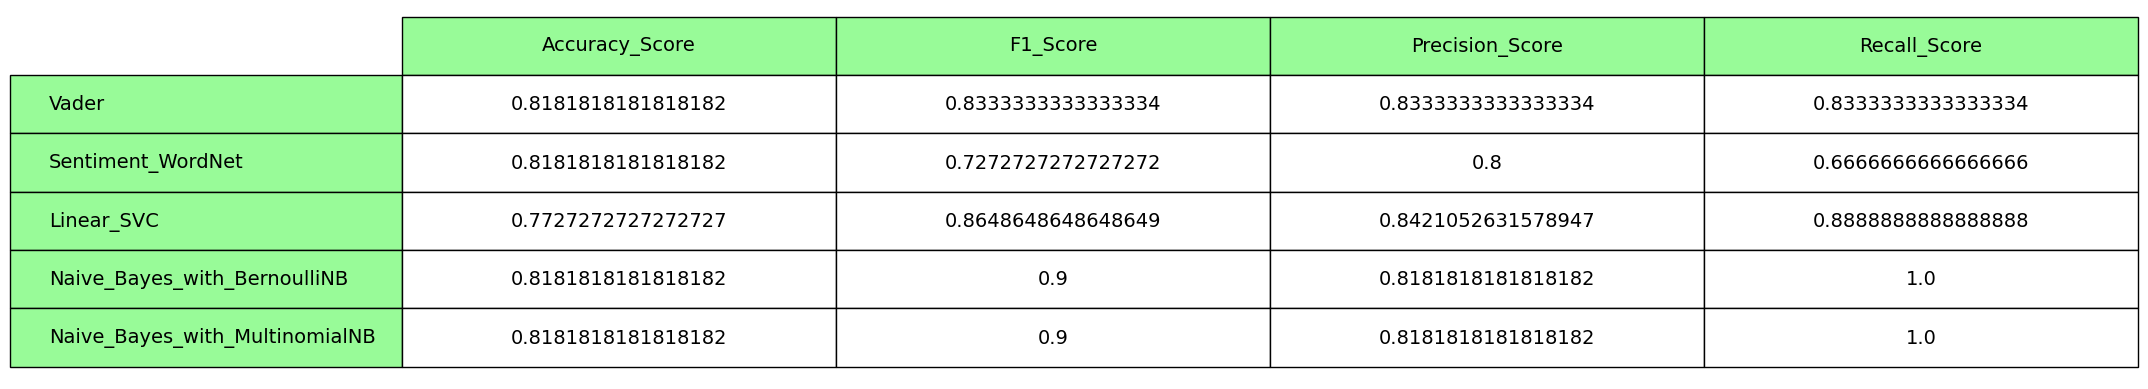

In [45]:
# precision, recall, f1, accuracy for all methods

lsvc_accuracy_score = nfeatures_accuracy[0][1].loc[4].accuracy_score
lsvc_f1_score = nfeatures_f1[0][1].loc[4].f1_score
lsvc_precision_score = nfeatures_precision[0][1].loc[4].precision_score
lsvc_recall_score = nfeatures_recall[0][1].loc[4].recall_score

bcbn_accuracy_score = nfeatures_accuracy[1][1].loc[4].accuracy_score
bcbn_f1_score = nfeatures_f1[1][1].loc[4].f1_score
bcbn_precision_score = nfeatures_precision[1][1].loc[4].precision_score
bcbn_recall_score = nfeatures_recall[1][1].loc[4].recall_score

bcmn_accuracy_score = nfeatures_accuracy[2][1].loc[4].accuracy_score
bcmn_f1_score = nfeatures_f1[2][1].loc[4].f1_score
bcmn_precision_score = nfeatures_precision[2][1].loc[4].precision_score
bcmn_recall_score = nfeatures_recall[2][1].loc[4].recall_score

val1 = ["Accuracy_Score", "F1_Score", "Precision_Score", "Recall_Score"] 
val2 = ["Vader", "Sentiment_WordNet", "Linear_SVC", "Naive_Bayes_with_BernoulliNB", "Naive_Bayes_with_MultinomialNB"] 
val3 = [[vader_accuracy_score, vader_f1_score, vader_precision_score, vader_recall_score],
        [wn_accuracy_score, wn_f1_score, wn_precision_score, wn_recall_score],
        [lsvc_accuracy_score, lsvc_f1_score, lsvc_precision_score, lsvc_recall_score],
        [bcbn_accuracy_score, bcbn_f1_score, bcbn_precision_score, bcbn_recall_score],
        [bcmn_accuracy_score, bcmn_f1_score, bcmn_precision_score, bcmn_recall_score]]
  
fig, ax = plt.subplots() 
ax.set_axis_off() 
table = ax.table( 
    cellText = val3,  
    rowLabels = val2,  
    colLabels = val1, 
    rowColours =["palegreen"] * 10,  
    colColours =["palegreen"] * 10, 
    cellLoc ='center',  
    loc ='upper left')  


# table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(14)
table.scale(3.5,3.5)
# ax.axis('off')

plt.show()